<a href="https://colab.research.google.com/github/itamarKraitman/Brain_Tumor_detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import pandas as pd
import os
from google.colab.patches import cv2_imshow
import cv2

import zipfile
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision import datasets
from torchvision.transforms import v2
import torch.optim as optim




In [ ]:
# Unzipping the data

with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/BrainToumorDataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

### Reading the pictures from the directories

In [ ]:
class BrainToumorData(Dataset):
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.labeled_images = []
        inner_folders = ['yes', 'no']
        image_data = []

        self.transform = v2.Compose([
            v2.RandomResizedCrop(size=(225,225), antialias=True), # what is it?, needed?
            v2.RandomRotation(45),
            v2.RandomZoomOut(p=0.2)
        ])

        # Loop through each inner folder
        for folder in inner_folders:
            # Get the inner folder path
            folder_path = os.path.join(data_folder, folder)

            # Get the list of files in the folder
            files = os.listdir(folder_path)

            # Create touples with image and it's label
            #labeled_images = [(os.path.join(file,), folder) for file in files]
            for image_path in files:
                image_inner_path = os.path.join(folder, image_path)
                full_image_path = os.path.join(data_folder, image_inner_path)
                # image = cv2.imread(full_image_path)
                # converted_image = preprocesing_image(image)
                self.labeled_images.append((full_image_path, folder))

        # self.transform = transform

        # if self.transform:
        #     self.image_data = [(self._apply_transform(image), label) for image, label in self.image_data]

    def _apply_transform(self, image):
        # Convert to uint8 before applying transform
        image_uint8 = _convert_to_uint8(image)

        # Apply the provided transform
        image_transformed = self.transform(image_uint8)

        return image_transformed

    def __len__(self):
        return len(self.labeled_images)

    def __getitem__(self, item):
        image_path, label = self.labeled_images[item]
        image = cv2.imread(image_path)

        resized_image = cv2.resize(image, (225, 225))
        normalized_image = resized_image / 255.0
        # converting image to tensor, and adding channel to make it gray scale by changing thr first channel to 1
        # 225,225 -> 1,225,225
        if len(normalized_image) == 2:
          image = torch.from_numpy(normalized_image).unsqueeze(0)
        else:
          #RGB case- h,w,3 -> 3,h,w
          image = torch.from_numpy(normalized_image).permute((2,0,1))
        label = 0 if label == "no" else 1

        # augmentation- take augmented image in 20%
        prob = torch.rand(1) < 0.2
        if prob:
          image = self.transform(image)

        return image, label


In [ ]:
data_folder = 'brain_tumor_dataset'

data = BrainToumorData(data_folder)

In [ ]:
print(f"label of first: {data[0][1]}, label of last: {data[-1][1]}")

label of first: 1, label of last: 0


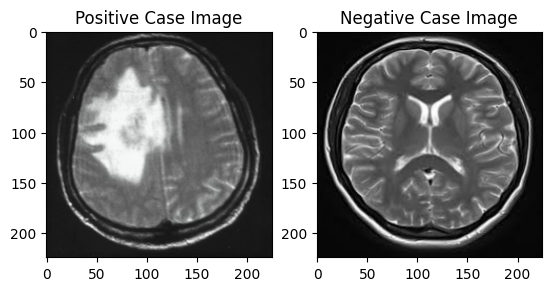

In [ ]:
positive_image = data[0][0]
negative_image = data[-1][0]

fix, axs = plt.subplots(1, 2)
axs[0].imshow(positive_image.permute(1,2,0))
axs[0].set_title('Positive Case Image')

axs[1].imshow(negative_image.permute(1,2,0))
axs[1].set_title('Negative Case Image')

plt.show()

In [ ]:
print(len([image for image in image_data if image[1] == 'yes']))
print(len([image for image in image_data if image[1] == 'no']))

155
98



### Data Augmentation

In [ ]:
# Aumentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

augmented_dir = 'brain_tumor_dataset/augmented'
os.makedirs(augmented_dir, exist_ok=True)

i = 0
for file in image_data:
    image, label = file[0], file[1]
    if label == 'no' and i <= 50:
        img_array = np.array(image)
        img_array = img_array.reshape((1,) + img_array.shape)

        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_dir,
                                  save_prefix='aug', save_format='png'):
            break
        i += 1

In [ ]:
# Adding all augmented pictures to the data set

files = os.listdir(augmented_dir)

labeled_images = []
# Create tuple with image and it's label
for image_path in files:
    full_image_path = os.path.join(augmented_dir, image_path)
    image = cv2.imread(full_image_path)
    converted_image = preprocesing_image(image)
    labeled_images.append((converted_image, 'no'))

image_data.extend(labeled_images)

# Making sure it worked
len(image_data)

355

In [ ]:
print(len([image for image in image_data if image[1] == 'yes']))
print(len([image for image in image_data if image[1] == 'no']))

155
200


<class 'numpy.ndarray'>


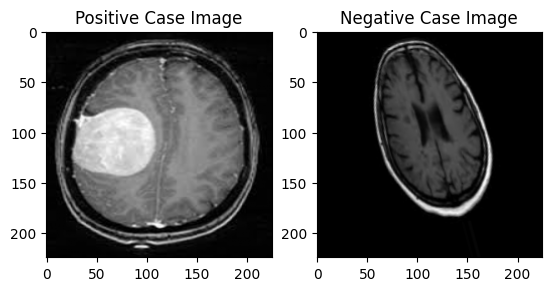

In [ ]:
positive_image = image_data[0][0]  # first picture is a positive case
negative_image = image_data[-1][0]  # last case is a negative case

fix, axs = plt.subplots(1, 2)
axs[0].imshow(positive_image)
axs[0].set_title('Positive Case Image')

axs[1].imshow(negative_image)
axs[1].set_title('Negative Case Image')

print(type(image_data[0][0]))

plt.show()

##### Preprocessing image_data to a compatible type for training with pyTorch

In [ ]:
# image_data is a list 0f np.ndarray

def _convert_to_uint8(image):
    # Assuming image is a float32 numpy array
    return (image * 255).astype(np.uint8)

class CustomData(Dataset):
    def __init__(self, image_data, transform=None):
        self.image_data = image_data
        self.transform = transform

        if self.transform:
            self.image_data = [(self._apply_transform(image), label) for image, label in self.image_data]

    def _apply_transform(self, image):
        # Convert to uint8 before applying transform
        image_uint8 = _convert_to_uint8(image)

        # Apply the provided transform
        image_transformed = self.transform(image_uint8)

        return image_transformed

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, item):
        image, label = self.image_data[item]
        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

custom_image_data = CustomData(image_data=image_data, transform=transform)

# data_loader = torch.utils.data.DataLoader(custom_image_data, batch_size=32, shuffle=True)

##### Splitting to train and validation sets

In [ ]:
# Define ratio for train and validation
train_ratio = 0.8
validation_ratio = 0.2

# Calculate number of samples for each set
total = len(custom_image_data)
train_size = int(train_ratio * total)
validation_size = total - train_size

# Create train and validation datasets
train_set, validation_set = torch.utils.data.random_split(custom_image_data, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32)

### Training RSNet
##### Using RSNet because of its excellent performance in image classification tasks

In [ ]:
# RSNet50 because of its popularity im CV tasks regarding for balance between depth and computational efficient of the model
rsnet_model = models.resnet50(pretrained=True)

C:\Users\itama\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\itama\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_classes = 2
rsnet_model.fc = torch.nn.Linear(rsnet_model.fc.in_features, num_classes)

##### Lost function and Optimizer

In [ ]:
# Cross Entropy loss function is commonly used in image classification
criterion = torch.nn.CrossEntropyLoss()
# SGD optimizer, using lr 0.001 and momentum 0.9 as starting points
optimizer = optim.SGD(rsnet_model.parameters(), lr=0.001, momentum=0.9)

##### Training and Validating

In [ ]:
def evaluate(model, data_loader):
    """
    Evaluating model performance
    :param model: pyTorch model
    :param data_loader: data
    :return: model accuracy
    """

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            labels_as_tensor = encode_labels(labels)
            outputs = model(inputs)
            # torch.max() returns tensor where the second dimension is the predicted scores for each class
            _, predicted = torch.max(outputs, 1)
            total += len(labels)
            equal_entries = torch.eq(predicted, labels_as_tensor)
            correct += torch.sum(equal_entries).item()

    accuracy = correct / total
    return accuracy

In [ ]:
num_epochs = 30
loss_history, val_loss_history = [], []


def encode_labels(labels):
    encoded_list = [1 if item == 'yes' else 0 for item in labels]

    # Convert the list to a PyTorch tensor
    return torch.tensor(encoded_list)


for epoch in range(num_epochs):
    # Setting the model to training mode
    rsnet_model.train()
    for inputs, labels in train_loader:
        labels_as_tensor = encode_labels(labels)
        # Zeroing out the gradients from previous batch so they won't influence the current batch
        optimizer.zero_grad()
        # Predicting
        outputs = rsnet_model(inputs)
        # Computing loss value
        loss = criterion(input=outputs, target=labels_as_tensor)
        # Backward propagating
        loss.backward()
        # Updating the model parameters based on the gradients computed during the backward pass
        optimizer.step()

    # Validating the model after each epoch
    rsnet_model.eval()
    with torch.no_grad(): # Disabling gradient computation
        for inputs, labels in validation_loader:
            labels_as_tensor_val = encode_labels(labels)
            outputs = rsnet_model(inputs)
            val_loss = criterion(outputs, labels_as_tensor_val)

    # Evaluate validation accuracy
    val_accuracy = evaluate(model=rsnet_model, data_loader=validation_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Val loss: {val_accuracy}")

    loss_history.append(loss.item())
    val_loss_history.append(val_accuracy)

Epoch 1/10, Loss: 0.5731407999992371, Val loss: 0.6445873975753784, val accuracy: 0.6111111111111112
Epoch 2/10, Loss: 0.5138107538223267, Val loss: 0.5066779255867004, val accuracy: 0.8518518518518519
Epoch 3/10, Loss: 0.25411829352378845, Val loss: 0.42142176628112793, val accuracy: 0.8148148148148148
Epoch 4/10, Loss: 0.13657806813716888, Val loss: 0.30384373664855957, val accuracy: 0.9814814814814815
Epoch 5/10, Loss: 0.22356151044368744, Val loss: 0.2932005226612091, val accuracy: 0.8888888888888888
Epoch 6/10, Loss: 0.04756380617618561, Val loss: 0.24740318953990936, val accuracy: 0.9259259259259259
Epoch 7/10, Loss: 0.03633303940296173, Val loss: 0.21262457966804504, val accuracy: 0.9814814814814815
Epoch 8/10, Loss: 0.05061717331409454, Val loss: 0.2156727910041809, val accuracy: 0.9629629629629629
Epoch 9/10, Loss: 0.023959174752235413, Val loss: 0.25121521949768066, val accuracy: 0.9629629629629629
Epoch 10/10, Loss: 0.021309463307261467, Val loss: 0.23918788135051727, val ac

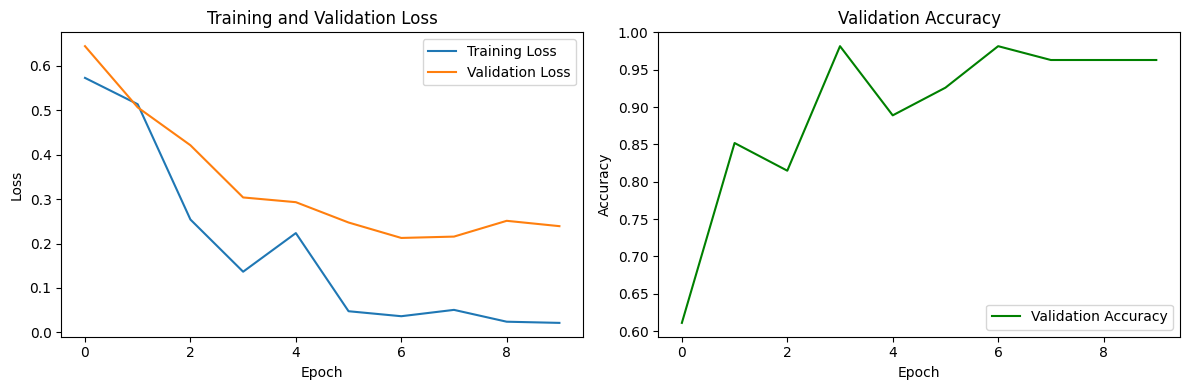

In [ ]:
metrics_data = {'loss': loss_history, 'val_loss': val_loss_history}
metrics_df = pd.DataFrame(metrics_data)
metrics_df.plot()

Max accuracy is: 0.9814814814814815
